<a href="https://colab.research.google.com/github/bhatianika/Parallel-Distributed/blob/main/102203919_Parallel_Assignment4%265.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ASSIGNMENT 4**

# **Problem 1**

In [ ]:
%%writefile sum_integers.cu
#include <stdio.h>

__global__ void sum_integers_iterative(int *input, int *output, int n) {
    int index = threadIdx.x + blockIdx.x * blockDim.x;
    int stride = blockDim.x * gridDim.x;
    int sum = 0;
    for (int i = index; i < n; i += stride) {
        sum += input[i];
    }
    atomicAdd(output, sum);
}

__global__ void sum_integers_formula(int *input, int *output, int n) {
    if (threadIdx.x == 0 && blockIdx.x == 0) {
        output[1] = n * (n + 1) / 2;
    }
}

int main() {
    int n;
    printf("Enter the value of N: ");
    scanf("%d", &n);

    int *d_input, *d_output;
    int output[2] = {0};

    cudaMalloc(&d_input, n * sizeof(int));
    cudaMalloc(&d_output, 2 * sizeof(int));

    // Initialize d_output on the device
    cudaMemset(d_output, 0, 2 * sizeof(int));

    int *input = (int*)malloc(n * sizeof(int));
    for (int i = 0; i < n; i++) {
        input[i] = i + 1;
    }
    cudaMemcpy(d_input, input, n * sizeof(int), cudaMemcpyHostToDevice);


    int blockSize = 256;
    int numBlocks = (n + blockSize - 1) / blockSize;

    sum_integers_iterative<<<numBlocks, blockSize>>>(d_input, d_output, n);
    cudaDeviceSynchronize();
    sum_integers_formula<<<1, 1>>>(d_input, d_output, n);
    cudaDeviceSynchronize();

    cudaMemcpy(output, d_output, 2 * sizeof(int), cudaMemcpyDeviceToHost);

    printf("Sum by iteration: %d\n", output[0]);
    printf("Sum by formula: %d\n", output[1]);

    free(input);
    cudaFree(d_input);
    cudaFree(d_output);

    return 0;
}








Overwriting sum_integers.cu


In [ ]:
!nvcc -o sum_integers sum_integers.cu
!./sum_integers


Enter the value of N: 1024
Sum by iteration: 0
Sum by formula: 0


# **Problem 2**

In [1]:
%%writefile mergesort_compare.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>
#include <cuda.h>

#define N 1000

void merge(int* arr, int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;

    int *L = (int*)malloc(n1 * sizeof(int));
    int *R = (int*)malloc(n2 * sizeof(int));

    for (i = 0; i < n1; i++) L[i] = arr[l + i];
    for (j = 0; j < n2; j++) R[j] = arr[m + 1 + j];

    i = 0; j = 0; k = l;
    while (i < n1 && j < n2) arr[k++] = (L[i] <= R[j]) ? L[i++] : R[j++];
    while (i < n1) arr[k++] = L[i++];
    while (j < n2) arr[k++] = R[j++];

    free(L);
    free(R);
}

void mergeSortPipeline(int* arr, int l, int r) {
    if (l < r) {
        int m = (l + r) / 2;
        #pragma omp parallel sections
        {
            #pragma omp section
            mergeSortPipeline(arr, l, m);
            #pragma omp section
            mergeSortPipeline(arr, m + 1, r);
        }
        merge(arr, l, m, r);
    }
}

__device__ void mergeCuda(int* arr, int* temp, int l, int m, int r) {
    int i = l, j = m + 1, k = l;
    while (i <= m && j <= r) temp[k++] = (arr[i] <= arr[j]) ? arr[i++] : arr[j++];
    while (i <= m) temp[k++] = arr[i++];
    while (j <= r) temp[k++] = arr[j++];
    for (int x = l; x <= r; x++) arr[x] = temp[x];
}

__global__ void mergeSortCuda(int* arr, int* temp, int width, int n) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int l = tid * (2 * width);
    int m = l + width - 1;
    int r = l + 2 * width - 1;
    if (r >= n) r = n - 1;
    if (m < r)
        mergeCuda(arr, temp, l, m, r);
}

void parallelMergeSortCuda(int* arr, int n) {
    int *d_arr, *d_temp;
    cudaMalloc(&d_arr, n * sizeof(int));
    cudaMalloc(&d_temp, n * sizeof(int));
    cudaMemcpy(d_arr, arr, n * sizeof(int), cudaMemcpyHostToDevice);

    for (int width = 1; width < n; width *= 2) {
        int numThreads = (n + (2 * width) - 1) / (2 * width);
        mergeSortCuda<<<(numThreads + 255) / 256, 256>>>(d_arr, d_temp, width, n);
        cudaDeviceSynchronize();
    }

    cudaMemcpy(arr, d_arr, n * sizeof(int), cudaMemcpyDeviceToHost);
    cudaFree(d_arr);
    cudaFree(d_temp);
}

void printArray(int* arr, int n) {
    for (int i = 0; i < n; i++) {
        printf("%d ", arr[i]);
        if ((i + 1) % 20 == 0) printf("\n");
    }
    printf("\n");
}

int main() {
    int* arr = (int*)malloc(N * sizeof(int));
    int* arr_copy = (int*)malloc(N * sizeof(int));
    srand(time(NULL));
    for (int i = 0; i < N; i++) {
        arr[i] = rand() % 10000;
        arr_copy[i] = arr[i];
    }

    printf("Unsorted Array:\n");
    printArray(arr, N);

    double start = omp_get_wtime();
    mergeSortPipeline(arr, 0, N - 1);
    double end = omp_get_wtime();
    printf("\nSorted Array using Pipelined Merge Sort:\n");
    printArray(arr, N);
    printf("\nPipelined Merge Sort Time: %.6f seconds\n", end - start);

    start = omp_get_wtime();
    parallelMergeSortCuda(arr_copy, N);
    end = omp_get_wtime();
    printf("\nSorted Array using CUDA Merge Sort:\n");
    printArray(arr_copy, N);
    printf("\nCUDA Merge Sort Time: %.6f seconds\n", end - start);

    free(arr);
    free(arr_copy);
    return 0;
}


Writing mergesort_compare.cu


In [2]:
!nvcc mergesort_compare.cu -o mergesort_compare -Xcompiler -fopenmp
!./mergesort_compare

Unsorted Array:
1834 4939 9773 1178 2452 9139 4077 1192 7352 8768 6667 471 1740 210 6538 8948 8240 6788 1414 2674 
8249 2007 3221 5723 6010 9856 7091 3628 5843 7813 4380 7677 9104 506 8856 1556 9645 9285 9100 3349 
8054 5767 3821 9794 2329 6711 5094 570 3499 2860 9596 8100 4867 2818 176 7230 9026 7267 7210 4869 
1432 1591 8899 536 2097 4107 8445 8094 3392 7545 1443 1446 3313 1616 7593 5642 8327 9039 2564 1827 
1900 8513 9927 3119 7683 6455 349 6709 3723 3912 7930 1507 5503 6829 2044 3952 7288 489 8398 681 
4386 9841 8479 7699 1458 6072 9694 9785 1464 8610 7964 9716 7123 4244 2835 4806 699 9537 7867 774 
3449 5798 2282 5304 8979 678 5608 6268 7519 4006 6949 1905 3847 1780 5957 1657 4205 5651 7795 5669 
4261 2111 5385 1385 6355 4572 2543 3407 4109 411 4181 3910 6209 6463 9214 1540 3493 1174 7808 1012 
5180 1109 2918 5380 2890 8875 7037 7095 878 1184 9116 5139 3296 4501 2876 9651 5425 5420 3058 5887 
2183 3592 9797 8392 6407 5364 9932 9901 6538 4093 913 1719 5202 183 3451 4444 9058 6840 1

In [3]:
%%writefile mergesort_compare.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>
#include <cuda.h>

int N;

void merge(int* arr, int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;

    int *L = (int*)malloc(n1 * sizeof(int));
    int *R = (int*)malloc(n2 * sizeof(int));

    for (i = 0; i < n1; i++) L[i] = arr[l + i];
    for (j = 0; j < n2; j++) R[j] = arr[m + 1 + j];

    i = 0; j = 0; k = l;
    while (i < n1 && j < n2) arr[k++] = (L[i] <= R[j]) ? L[i++] : R[j++];
    while (i < n1) arr[k++] = L[i++];
    while (j < n2) arr[k++] = R[j++];

    free(L);
    free(R);
}

void mergeSortPipeline(int* arr, int l, int r) {
    if (l < r) {
        int m = (l + r) / 2;
        #pragma omp parallel sections
        {
            #pragma omp section
            mergeSortPipeline(arr, l, m);
            #pragma omp section
            mergeSortPipeline(arr, m + 1, r);
        }
        merge(arr, l, m, r);
    }
}

__device__ void mergeCuda(int* arr, int* temp, int l, int m, int r) {
    int i = l, j = m + 1, k = l;
    while (i <= m && j <= r) temp[k++] = (arr[i] <= arr[j]) ? arr[i++] : arr[j++];
    while (i <= m) temp[k++] = arr[i++];
    while (j <= r) temp[k++] = arr[j++];
    for (int x = l; x <= r; x++) arr[x] = temp[x];
}

__global__ void mergeSortCuda(int* arr, int* temp, int width, int n) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int l = tid * (2 * width);
    int m = l + width - 1;
    int r = l + 2 * width - 1;
    if (r >= n) r = n - 1;
    if (m < r)
        mergeCuda(arr, temp, l, m, r);
}

void parallelMergeSortCuda(int* arr, int n) {
    int *d_arr, *d_temp;
    cudaMalloc(&d_arr, n * sizeof(int));
    cudaMalloc(&d_temp, n * sizeof(int));
    cudaMemcpy(d_arr, arr, n * sizeof(int), cudaMemcpyHostToDevice);

    for (int width = 1; width < n; width *= 2) {
        int numThreads = (n + (2 * width) - 1) / (2 * width);
        mergeSortCuda<<<(numThreads + 255) / 256, 256>>>(d_arr, d_temp, width, n);
        cudaDeviceSynchronize();
    }

    cudaMemcpy(arr, d_arr, n * sizeof(int), cudaMemcpyDeviceToHost);
    cudaFree(d_arr);
    cudaFree(d_temp);
}

void printArray(int* arr, int n) {
    for (int i = 0; i < n; i++) {
        printf("%d ", arr[i]);
        if ((i + 1) % 20 == 0) printf("\n");
    }
    printf("\n");
}

int main(int argc, char** argv) {
    if (argc != 2) {
    printf("Usage: %s <array_size>\n", argv[0]);
    return 1;
    }
    N = atoi(argv[1]);

    int* arr = (int*)malloc(N * sizeof(int));
    int* arr_copy = (int*)malloc(N * sizeof(int));
    srand(time(NULL));
    for (int i = 0; i < N; i++) {
        arr[i] = rand() % 10000;
        arr_copy[i] = arr[i];
    }

    printf("Unsorted Array:\n");
    printArray(arr, N);

    double start = omp_get_wtime();
    mergeSortPipeline(arr, 0, N - 1);
    double end = omp_get_wtime();
    printf("\nSorted Array using Pipelined Merge Sort:\n");
    printArray(arr, N);
    printf("\nPipelined Merge Sort Time: %.6f seconds\n", end - start);

    start = omp_get_wtime();
    parallelMergeSortCuda(arr_copy, N);
    end = omp_get_wtime();
    printf("\nSorted Array using CUDA Merge Sort:\n");
    printArray(arr_copy, N);
    printf("\nCUDA Merge Sort Time: %.6f seconds\n", end - start);

    free(arr);
    free(arr_copy);
    return 0;
}

Overwriting mergesort_compare.cu


In [4]:
!nvcc mergesort_compare.cu -o mergesort_compare -Xcompiler -fopenmp
!./mergesort_compare 10000

Unsorted Array:
1960 7089 9639 5879 4273 191 3965 9016 6596 3542 2132 6550 3885 5767 70 5752 6264 3572 5539 2711 
4730 6549 9863 8290 1179 5090 828 1865 1663 7883 7530 3623 1324 3522 5854 5597 3713 9819 966 310 
3361 3098 3212 3598 5217 3282 5702 1481 6855 1242 545 1585 4143 6760 9875 1674 8203 7055 3539 9866 
4939 1070 9841 2615 4592 5695 8213 4657 1866 5531 1319 5227 4981 4531 5177 198 7814 880 8031 4669 
8474 4928 2606 2617 1689 8833 4291 9892 5888 4183 6110 7179 5253 5951 9795 6197 1646 4360 7206 3512 
9891 8526 5091 4872 3057 6620 1422 7223 3852 5805 8244 2326 734 7202 1295 2423 6035 1939 8667 8276 
6122 4777 1807 7727 728 1602 276 8726 2314 7482 8590 8557 2360 33 3429 1770 6653 1203 8993 506 
7009 7238 2832 7743 4440 480 6518 6828 2419 5185 5104 4893 6314 6911 2620 3394 4866 2896 2120 7180 
6730 7062 5738 9091 7095 5519 861 3748 3075 9854 4254 84 3444 3439 4179 4237 271 697 1065 2690 
2234 2521 3935 4900 9432 6555 8294 650 5803 6766 4183 2533 3828 9921 7976 923 1792 5189 1023 486

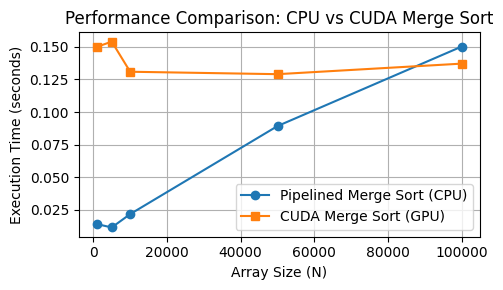

In [5]:
import subprocess
import matplotlib.pyplot as plt

sizes = [1000, 5000, 10000, 50000, 100000]
cpu_times = []
gpu_times = []


!nvcc -Xcompiler -fopenmp mergesort_compare.cu -o mergesort_compare

for size in sizes:
    result = subprocess.run(
        ['./mergesort_compare', str(size)],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    output = result.stdout


    cpu_line = [line for line in output.splitlines() if "Pipelined Merge Sort Time" in line]
    gpu_line = [line for line in output.splitlines() if "CUDA Merge Sort Time" in line]

    cpu_time = float(cpu_line[0].split()[-2])
    gpu_time = float(gpu_line[0].split()[-2])

    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)


plt.figure(figsize=(5, 3))
plt.plot(sizes, cpu_times, label='Pipelined Merge Sort (CPU)', marker='o')
plt.plot(sizes, gpu_times, label='CUDA Merge Sort (GPU)', marker='s')
plt.xlabel('Array Size (N)')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance Comparison: CPU vs CUDA Merge Sort')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **ASSIGNMENT 5**

# **1.1**

In [6]:
%%writefile 1.1.cu
#include <stdio.h>
#include <cuda_runtime.h>

#define N 1048576
__device__ float d_A[N];
__device__ float d_B[N];
__device__ float d_C[N];

__global__ void vectorAdd(int n)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
    {
        d_C[i] = d_A[i] + d_B[i];
    }
}

__global__ void initializeArrays(int n)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
    {
        d_A[i] = i;
        d_B[i] = 2 * i;
    }
}

int main(void)
{
    cudaError_t err = cudaSuccess;

    printf("Vector addition of %d elements\n", N);

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    printf("CUDA kernel launch with %d blocks of %d threads\n", blocksPerGrid, threadsPerBlock);

    initializeArrays<<<blocksPerGrid, threadsPerBlock>>>(N);
    err = cudaGetLastError();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to launch initialize kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    cudaDeviceSynchronize();

    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(N);
    err = cudaGetLastError();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to launch vectorAdd kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    cudaDeviceSynchronize();

    float h_C[10]; // Just verify first 10 elements to avoid memory issues
    err = cudaMemcpyFromSymbol(h_C, d_C, 10 * sizeof(float));
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to copy result array from device to host (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    for (int i = 0; i < 10; i++)
    {
        float expected = i + 2*i;
        if (fabs(h_C[i] - expected) > 1e-5)
        {
            fprintf(stderr, "Result verification failed at element %d!\n", i);
            exit(EXIT_FAILURE);
        }
    }

    printf("Test PASSED\n");

    err = cudaDeviceReset();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to deinitialize the device! error=%s\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    printf("Done\n");
    return 0;
}

Writing 1.1.cu


In [7]:
!nvcc 1.1.cu -o 1.1 -arch=sm_75
!./1.1

Vector addition of 1048576 elements
CUDA kernel launch with 4096 blocks of 256 threads
Test PASSED
Done


In [8]:
!nvprof ./1.1

Vector addition of 1048576 elements
CUDA kernel launch with 4096 blocks of 256 threads
==3347== NVPROF is profiling process 3347, command: ./1.1
Test PASSED
Done
==3347== Profiling application: ./1.1
==3347== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   57.59%  54.367us         1  54.367us  54.367us  54.367us  vectorAdd(int)
                   39.97%  37.727us         1  37.727us  37.727us  37.727us  initializeArrays(int)
                    2.44%  2.3040us         1  2.3040us  2.3040us  2.3040us  [CUDA memcpy DtoH]
      API calls:   75.53%  101.31ms         2  50.656ms  7.9240us  101.30ms  cudaLaunchKernel
                   23.56%  31.609ms         1  31.609ms  31.609ms  31.609ms  cudaDeviceReset
                    0.71%  948.39us         1  948.39us  948.39us  948.39us  cudaMemcpyFromSymbol
                    0.11%  147.67us       114  1.2950us     120ns  60.872us  cuDeviceGetAttribute
                    0

# **1.2**

In [9]:
%%writefile 1.2.cu
#include <stdio.h>
#include <cuda_runtime.h>
#define N 1048576
__device__ float d_A[N];
__device__ float d_B[N];
__device__ float d_C[N];

__global__ void vectorAdd(int n)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
    {
        d_C[i] = d_A[i] + d_B[i];
    }
}

__global__ void initializeArrays(int n)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
    {
        d_A[i] = i;
        d_B[i] = 2 * i;
    }
}

int main(void)
{
    cudaError_t err = cudaSuccess;

    printf("Vector addition of %d elements\n", N);

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    printf("CUDA kernel launch with %d blocks of %d threads\n", blocksPerGrid, threadsPerBlock);

    initializeArrays<<<blocksPerGrid, threadsPerBlock>>>(N);
    err = cudaGetLastError();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to launch initialize kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    cudaDeviceSynchronize();

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start, NULL);

    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(N);
    err = cudaGetLastError();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to launch vectorAdd kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    cudaEventRecord(stop, NULL);

    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    printf("Kernel execution time: %f ms\n", milliseconds);

    float h_C[10]; // Just verify first 10 elements
    err = cudaMemcpyFromSymbol(h_C, d_C, 10 * sizeof(float));
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to copy result array from device to host (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    for (int i = 0; i < 10; i++)
    {
        float expected = i + 2*i;
        if (fabs(h_C[i] - expected) > 1e-5)
        {
            fprintf(stderr, "Result verification failed at element %d!\n", i);
            exit(EXIT_FAILURE);
        }
    }

    printf("Test PASSED\n");

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    err = cudaDeviceReset();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to deinitialize the device! error=%s\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    printf("Done\n");
    return 0;
}

Writing 1.2.cu


In [10]:
!nvcc 1.2.cu -o 1.2 -arch=sm_75
!./1.2

Vector addition of 1048576 elements
CUDA kernel launch with 4096 blocks of 256 threads
Kernel execution time: 0.096608 ms
Test PASSED
Done


In [11]:
!nvprof ./1.2

Vector addition of 1048576 elements
CUDA kernel launch with 4096 blocks of 256 threads
==3736== NVPROF is profiling process 3736, command: ./1.2
Kernel execution time: 0.068672 ms
Test PASSED
Done
==3736== Profiling application: ./1.2
==3736== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   57.51%  54.655us         1  54.655us  54.655us  54.655us  vectorAdd(int)
                   40.07%  38.079us         1  38.079us  38.079us  38.079us  initializeArrays(int)
                    2.42%  2.3040us         1  2.3040us  2.3040us  2.3040us  [CUDA memcpy DtoH]
      API calls:   74.36%  118.47ms         2  59.235ms  10.734us  118.46ms  cudaLaunchKernel
                   25.41%  40.479ms         1  40.479ms  40.479ms  40.479ms  cudaDeviceReset
                    0.13%  201.07us       114  1.7630us     216ns  77.507us  cuDeviceGetAttribute
                    0.04%  55.964us         1  55.964us  55.964us  55.964us  cudaEve

# **1.3**

In [12]:
%%writefile 1.3.cu
#include <stdio.h>
#include <cuda_runtime.h>
#define N 1048576
__device__ float d_A[N];
__device__ float d_B[N];
__device__ float d_C[N];

__global__ void vectorAdd(int n)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
    {
        d_C[i] = d_A[i] + d_B[i];
    }
}

__global__ void initializeArrays(int n)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
    {
        d_A[i] = i;
        d_B[i] = 2 * i;
    }
}

int main(void)
{
    cudaError_t err = cudaSuccess;

    printf("Vector addition of %d elements\n", N);

    cudaDeviceProp deviceProp;
    err = cudaGetDeviceProperties(&deviceProp, 0);
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to get device properties (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    float memClockRate = deviceProp.memoryClockRate * 1000;
    float memBusWidth = deviceProp.memoryBusWidth;
    float theoreticalBW = (memClockRate * memBusWidth * 2) / 8.0f;
    theoreticalBW = theoreticalBW / 1.0e9f; // Convert to GB/s

    printf("Device: %s\n", deviceProp.name);
    printf("Memory Clock Rate (KHz): %d\n", deviceProp.memoryClockRate);
    printf("Memory Bus Width (bits): %d\n", deviceProp.memoryBusWidth);
    printf("Theoretical Bandwidth (GB/s): %f\n", theoreticalBW);

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    printf("CUDA kernel launch with %d blocks of %d threads\n", blocksPerGrid, threadsPerBlock);

    initializeArrays<<<blocksPerGrid, threadsPerBlock>>>(N);
    err = cudaGetLastError();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to launch initialize kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    cudaDeviceSynchronize();

    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(N);
    err = cudaGetLastError();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to launch vectorAdd kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    cudaDeviceSynchronize();

    float h_C[10]; // Just verify first 10 elements
    err = cudaMemcpyFromSymbol(h_C, d_C, 10 * sizeof(float));
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to copy result array from device to host (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    for (int i = 0; i < 10; i++)
    {
        float expected = i + 2*i;
        if (fabs(h_C[i] - expected) > 1e-5)
        {
            fprintf(stderr, "Result verification failed at element %d!\n", i);
            exit(EXIT_FAILURE);
        }
    }

    printf("Test PASSED\n");

    err = cudaDeviceReset();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to deinitialize the device! error=%s\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    printf("Done\n");
    return 0;
}

Writing 1.3.cu


In [13]:
!nvcc 1.3.cu -o 1.3 -arch=sm_75
!./1.3

Vector addition of 1048576 elements
Device: Tesla T4
Memory Clock Rate (KHz): 5001000
Memory Bus Width (bits): 256
Theoretical Bandwidth (GB/s): 45.186092
CUDA kernel launch with 4096 blocks of 256 threads
Test PASSED
Done


In [14]:
!nvprof ./1.3

Vector addition of 1048576 elements
==4113== NVPROF is profiling process 4113, command: ./1.3
Device: Tesla T4
Memory Clock Rate (KHz): 5001000
Memory Bus Width (bits): 256
Theoretical Bandwidth (GB/s): 45.186092
CUDA kernel launch with 4096 blocks of 256 threads
Test PASSED
Done
==4113== Profiling application: ./1.3
==4113== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   57.69%  54.271us         1  54.271us  54.271us  54.271us  vectorAdd(int)
                   39.83%  37.471us         1  37.471us  37.471us  37.471us  initializeArrays(int)
                    2.48%  2.3360us         1  2.3360us  2.3360us  2.3360us  [CUDA memcpy DtoH]
      API calls:   75.32%  94.555ms         2  47.277ms  26.671us  94.528ms  cudaLaunchKernel
                   24.36%  30.581ms         1  30.581ms  30.581ms  30.581ms  cudaDeviceReset
                    0.14%  170.84us       114  1.4980us     121ns  72.870us  cuDeviceGetAttribute


# **1.4**

In [15]:
%%writefile 1.4.cu
#include <stdio.h>
#include <cuda_runtime.h>
#define N 1048576
__device__ float d_A[N];
__device__ float d_B[N];
__device__ float d_C[N];

__global__ void vectorAdd(int n)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
    {
        d_C[i] = d_A[i] + d_B[i];
    }
}

__global__ void initializeArrays(int n)
{
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    if (i < n)
    {
        d_A[i] = i;
        d_B[i] = 2 * i;
    }
}

int main(void)
{
    cudaError_t err = cudaSuccess;

    printf("Vector addition of %d elements\n", N);

    cudaDeviceProp deviceProp;
    err = cudaGetDeviceProperties(&deviceProp, 0);
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to get device properties (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    float memClockRate = deviceProp.memoryClockRate * 1000;
    float memBusWidth = deviceProp.memoryBusWidth;
    float theoreticalBW = (memClockRate * memBusWidth * 2) / 8.0f;
    theoreticalBW = theoreticalBW / 1.0e9f; // Convert to GB/s

    printf("Device: %s\n", deviceProp.name);
    printf("Memory Clock Rate (KHz): %d\n", deviceProp.memoryClockRate);
    printf("Memory Bus Width (bits): %d\n", deviceProp.memoryBusWidth);
    printf("Theoretical Bandwidth (GB/s): %f\n", theoreticalBW);

    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    printf("CUDA kernel launch with %d blocks of %d threads\n", blocksPerGrid, threadsPerBlock);

    initializeArrays<<<blocksPerGrid, threadsPerBlock>>>(N);
    err = cudaGetLastError();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to launch initialize kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    cudaDeviceSynchronize();

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start, NULL);

    vectorAdd<<<blocksPerGrid, threadsPerBlock>>>(N);
    err = cudaGetLastError();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to launch vectorAdd kernel (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    cudaEventRecord(stop, NULL);

    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    printf("Kernel execution time: %f ms\n", milliseconds);

    size_t bytesRead = 2 * sizeof(float) * N;
    size_t bytesWritten = sizeof(float) * N;
    float totalBytes = (float)(bytesRead + bytesWritten);
    float seconds = milliseconds / 1000.0f;
    float measuredBW = totalBytes / seconds / 1.0e9f;

    printf("Data read: %.2f MB\n", bytesRead / (1024.0f * 1024.0f));
    printf("Data written: %.2f MB\n", bytesWritten / (1024.0f * 1024.0f));
    printf("Measured Bandwidth (GB/s): %.2f\n", measuredBW);
    printf("Bandwidth utilization: %.2f%%\n", (measuredBW / theoreticalBW) * 100.0f);

    float h_C[10]; // Just verify first 10 elements
    err = cudaMemcpyFromSymbol(h_C, d_C, 10 * sizeof(float));
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to copy result array from device to host (error code %s)!\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    for (int i = 0; i < 10; i++)
    {
        float expected = i + 2*i;
        if (fabs(h_C[i] - expected) > 1e-5)
        {
            fprintf(stderr, "Result verification failed at element %d!\n", i);
            exit(EXIT_FAILURE);
        }
    }

    printf("Test PASSED\n");

    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    err = cudaDeviceReset();
    if (err != cudaSuccess)
    {
        fprintf(stderr, "Failed to deinitialize the device! error=%s\n", cudaGetErrorString(err));
        exit(EXIT_FAILURE);
    }

    printf("Done\n");
    return 0;
}

Writing 1.4.cu


In [16]:
!nvcc 1.4.cu -o 1.4 -arch=sm_75
!./1.4

Vector addition of 1048576 elements
Device: Tesla T4
Memory Clock Rate (KHz): 5001000
Memory Bus Width (bits): 256
Theoretical Bandwidth (GB/s): 45.186092
CUDA kernel launch with 4096 blocks of 256 threads
Kernel execution time: 0.070976 ms
Data read: 8.00 MB
Data written: 4.00 MB
Measured Bandwidth (GB/s): 177.28
Bandwidth utilization: 392.34%
Test PASSED
Done


In [17]:
!nvprof ./1.4

Vector addition of 1048576 elements
==4434== NVPROF is profiling process 4434, command: ./1.4
Device: Tesla T4
Memory Clock Rate (KHz): 5001000
Memory Bus Width (bits): 256
Theoretical Bandwidth (GB/s): 45.186092
CUDA kernel launch with 4096 blocks of 256 threads
Kernel execution time: 0.069920 ms
Data read: 8.00 MB
Data written: 4.00 MB
Measured Bandwidth (GB/s): 179.96
Bandwidth utilization: 398.27%
Test PASSED
Done
==4434== Profiling application: ./1.4
==4434== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   57.39%  54.272us         1  54.272us  54.272us  54.272us  vectorAdd(int)
                   40.17%  37.983us         1  37.983us  37.983us  37.983us  initializeArrays(int)
                    2.44%  2.3040us         1  2.3040us  2.3040us  2.3040us  [CUDA memcpy DtoH]
      API calls:   75.69%  98.192ms         2  49.096ms  12.930us  98.179ms  cudaLaunchKernel
                   23.95%  31.076ms         1  31.